In [64]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler
import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray
from eofs.xarray import Eof
from xeofs.xarray import EOF
import gc
import collections
import statsmodels.api as sm
import scipy
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import product
import pyproj
from shapely.geometry import mapping

In [2]:
import mpas_analysis

In [ ]:
pyproj.set_use_global_context(True)

In [2]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS

# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'

# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Folder for output figures
figures_folderpath = 'reports/figures/' 

interim_data_folder = 'data/interim/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
reconstructions_neofs_path = 'reconstructions_neofs/'

In [3]:
iceShelvesToPlot = ['Antarctica', 'Peninsula', 'West Antarctica',
                    'East Antarctica', 'Larsen_C', 'Filchner', 'Ronne',
                    'Filchner-Ronne', 'Brunt_Stancomb', 'Fimbul', 'Amery',
                    'Totten', 'Eastern_Ross', 'Western_Ross', 'Ross', 'Getz',
                    'Thwaites', 'Pine_Island', 'Abbot', 'George_VI']
iceShelvesToPlot = np.asarray(iceShelvesToPlot)

In [ ]:
# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)
# Convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();

In [ ]:
plt.figure(figsize=(20,8))
ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
ax1.gridlines()
icems[6:33].boundary.plot(ax=ax1,linewidth=0.5)
ax1.coastlines(resolution='10m', zorder=6,linewidth=0.75)
icems.loc[[0]].plot(ax=ax1)
icems.loc[[1]].plot(ax=ax1)
icems.loc[[3]].plot(ax=ax1)
#icems.loc[[4]].plot(ax=ax1)
#icems.loc[[50]].plot(ax=ax1)
icems.loc[[5]].plot(ax=ax1)
#icems.loc[[56]].plot(ax=ax1)
plt.title('Catchment Boundaries')

In [ ]:
from mpas_analysis.shared.analysis_task import AnalysisTask

In [ ]:
from geometric_features import read_feature_collection

fc = read_feature_collection('test.geojson')

In [ ]:
fc.plot(projection=ccrs.SouthPolarStereo())

In [ ]:
import xarray as xr
import geopandas as gpd
import rioxarray


# 3 dimensional dataset
total_data = xr.open_dataset('.nc')
catchment_data = total_data.rio.clip(icems.loc[[43],'geometry'])

In [ ]:
fluxnp = flux_clean.to_numpy()
catchment_data = .rio.clip(icems.loc[[43],'geometry'])

In [5]:
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

In [6]:
%%time
model = EOF(flux_clean)
model.solve()
xeofs_eofs = model.eofs()
xeofs_pcs = model.pcs()
xeofs_n_modes = model.n_modes

CPU times: user 2min 40s, sys: 53.9 s, total: 3min 34s
Wall time: 58.3 s


In [98]:
plt.rcParams.update({'font.size': 18})

In [126]:
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica Neue')

In [115]:
sum(xeofs_n_eig[:75])

<xarray.DataArray 'explained_variance_ratio' ()>
array(0.96534121)
Coordinates:
    mode     int64 75

Text(0.5, 1.0, 'Relative Power of EOFs')

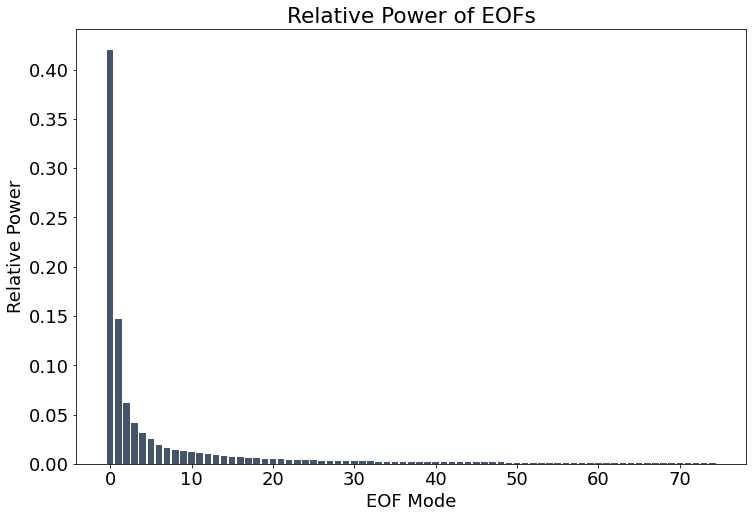

In [127]:
plt.figure(figsize=(12,8))
plt.bar(range(75),xeofs_n_eig[:75], color='#44546A')
plt.ylabel('Relative Power')
plt.xlabel('EOF Mode')
plt.title('Relative Power of EOFs')

In [10]:
xeofs_n_eig = model.explained_variance_ratio()

In [ ]:
plt.psd(xeofs_pcs[:,100])

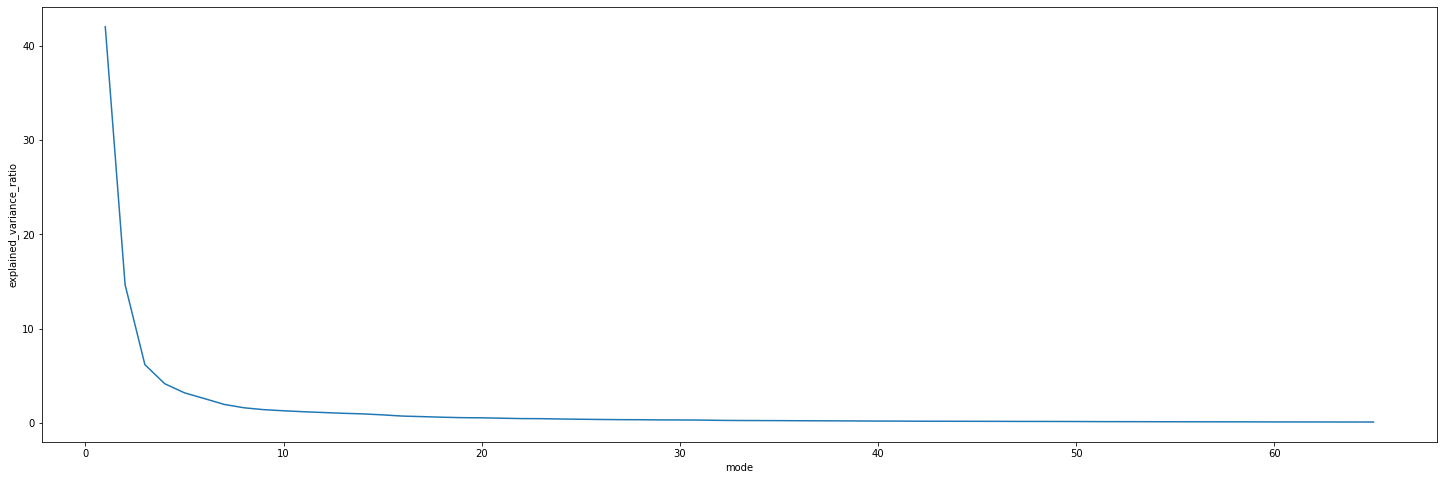

In [31]:
plt.figure(figsize=(25,8))
(xeofs_n_eig[:65]*100).plot()
#plt.errorbar(range(80),xeofs_n_eig[:80]*100)
#plt.plot(xeofs_n_eig,'*')

In [44]:
sum(xeofs_n_eig[:80]*100)

<xarray.DataArray 'explained_variance_ratio' ()>
array(96.81119409)

In [27]:
xeofs_n_eig

<xarray.DataArray 'explained_variance_ratio' (mode: 1500)>
array([4.20248301e-01, 1.46527420e-01, 6.16461167e-02, ...,
       1.80683648e-33, 1.80683648e-33, 5.80122044e-34])
Coordinates:
  * mode     (mode) int64 1 2 3 4 5 6 7 8 ... 1494 1495 1496 1497 1498 1499 1500

In [65]:
amery_basin = 34
#amery_flux = clip_data(flux_clean, amery_basin)
amery_flux = flux_clean.rio.clip(icems.loc[[amery_basin],'geometry'].apply(mapping),icems.crs,drop=False)

In [68]:
amflux = amery_flux.fillna(0)
flux_amremoved = flux_clean - amflux

In [74]:
ameigs = ammodel.explained_variance_ratio()

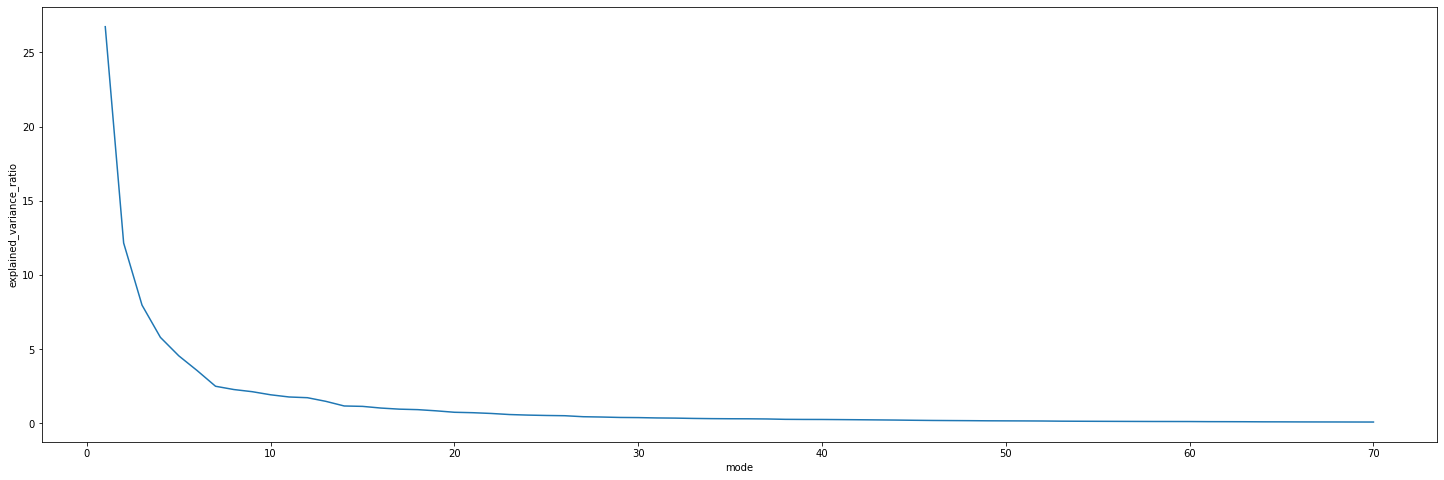

In [76]:
plt.figure(figsize=(25,8))
(ameigs[:70]*100).plot()

In [70]:
%%time
ammodel = EOF(flux_amremoved)
ammodel.solve()
am_eofs = ammodel.eofs()
am_pcs = ammodel.pcs()
am_n_modes = ammodel.n_modes

CPU times: user 2min 40s, sys: 56.8 s, total: 3min 37s
Wall time: 58.8 s


In [ ]:
%%time
##############################
# FOURIER PHASE RANDOMIZATION 
##############################

# Define number of random Fourier realizations
n_realizations = 1
t_length = xeofs_pcs.shape[0]

# xeofs_pcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,xeofs_pcs.shape[0],xeofs_pcs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(xeofs_n_modes):
        fl = xeofs_pcs[:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
        print('calculated ifft for realization i, mode: {}'.format(m))

In [ ]:
# Reconstruct flux dataset using phase randomized PCs.
# This section is to be called iteratively for ensemble runs with multiple realizations.
# This method also takes 'modes' as a parameter - used to reconstruct dataset with different number of selected modes
mode_skip = 1
def generate_data(mode):
    flux_reconstr = model.reconstruct_randomized_X(new_fl[0],slice(1,mode,mode_skip))
    return flux_reconstr

In [61]:
def clip_data(total_data, basin):
    with rioxarray.set_options(export_grid_mapping=False):
        clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'],from_disk=True).apply(mapping).squeeze()
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    #clipped_data = clipped_data.drop("month")
    return clipped_data

In [ ]:
def time_series(clipped_data):
    clipped_ts = clipped_data.sum(['y','x'])
    return clipped_ts

In [ ]:
def psd_calc(time_series):
    psd_arr = plt.psd(time_series)
    return psd_arr

In [ ]:
#basins = [34,55,104,114]
basins = [34]
xeofs_modes = list(range(1,xeofs_n_modes+1))
#xeofs_modes = list(range(1,10))

In [ ]:
orig_basin = clip_data(flux_clean, basins[0])
orig_basin_ts = time_series(orig_basin)
orig = psd_calc(orig_basin_ts)
orignp = np.asarray(orig)

In [ ]:
%%time
flux_reconstr = generate_data(59)

In [ ]:
8*1500/60/60

In [ ]:
%%time
rec_basin = clip_data(flux_reconstr, basins[0])

In [ ]:
def basinplot_func_clean(basin, mode):
    print("Generating reconstructed data, mode = {}".format(mode*mode_skip))
    flux_reconstr = generate_data(mode)
    print("Clipping reconstructed data")
    rec_basin = clip_data(flux_reconstr, basin)
    rec_basin_ts = time_series(rec_basin)
    rec = psd_calc(rec_basin_ts);
    rmse = sqrt(mean_squared_error(10*np.log10(rec[0]),10*np.log10(orig[0])))
    rec = np.asarray(rec)
    del flux_reconstr, rec_basin, rec_basin_ts
    gc.collect()
    return rmse, rec

In [ ]:
%%time
rmse_results, rec_results = list(map(basinplot_func_clean, *zip(*product(basins,xeofs_modes))))

In [ ]:
%%time
basin = basins[0]
n_reconstr = xeofs_n_modes
rmse_results = []
rec_results = np.empty((n_reconstr,orignp.shape[0],orignp.shape[1]))
for mode in range(1,n_reconstr+1):
    rmse, recc = basinplot_func_clean(basin, mode)
    rmse_results.append(rmse)
    rec_results[mode,:,:] = recc
    del recc
    gc.collect()

np.save('rec_55.npy',rec_results)
np.save('rmse_55.npy',rmse_results)

In [ ]:
np.save('rec_55.npy',rec_results)
np.save('rmse_55.npy',rmse_results)

In [ ]:
cmap = plt.cm.Greens
rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 0.1, 1)))

In [ ]:
plt.figure(figsize=(25,8))
for i in range(10, n_reconstr):
    plt.plot(rec_results[i,1,:], 10*np.log10(rec_results[i,0,:]), linewidth=0.3, color = cmap(i*10/n_reconstr))
plt.plot(orig[1], 10*np.log10(orig[0]), label='Original', linewidth=3, color='k')
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.title('Thwaites: PSD Comparison of Reconstructed Data')
plt.legend()

In [ ]:
np.save('rec_114.npy',rec_results)

In [ ]:
rmse104 = np.load('rmse_104.npy')
rmse34 = np.load('rmse_34.npy')
rmse114 = np.load('rmse_114.npy')
rmse55 = np.load('rmse_55.npy')

In [ ]:
rec114 = np.load('rec_114.npy')
rec55 = np.load('rec_55.npy')

In [ ]:
rmse_mode_min = 0
rmse_mode_max = 1500

In [ ]:
plt.subplots(2,2,figsize=(22,18))
plt.subplot(221)
plt.plot(rmse104[rmse_mode_min:rmse_mode_max], color='black')
plt.plot(np.argmin(rmse104),np.min(rmse104),"o", color='r')
plt.xlabel('# of EOF Modes used in Reconstruction')
plt.ylabel('RMSE of PSDs')
plt.title('PSD RMSE for Western Ross basin, Min RMSE occurs at {} modes'.format(np.argmin(rmse104)))

plt.subplot(222)
plt.plot(rmse34[rmse_mode_min+3:rmse_mode_max], color='black')
plt.plot(np.argmin(rmse34[3:]),np.min(rmse34[3:]),"o", color='r')
plt.xlabel('# of EOF Modes used in Reconstruction')
plt.ylabel('RMSE of PSDs')
plt.title('PSD RMSE for Amery basin, Min RMSE occurs at {} modes'.format(np.argmin(rmse34[3:])))

plt.subplot(223)
plt.plot(rmse114[rmse_mode_min:rmse_mode_max], color='black')
plt.plot(np.argmin(rmse114),np.min(rmse114),"o", color='r')
plt.xlabel('# of EOF Modes used in Reconstruction')
plt.ylabel('RMSE of PSDs')
plt.title('PSD RMSE for Thwaites basin, Min RMSE occurs at {} modes'.format(np.argmin(rmse114)))

plt.subplot(224)
plt.plot(rmse55[rmse_mode_min:rmse_mode_max], color='black')
plt.plot(np.argmin(rmse55),np.min(rmse55),"o", color='r')
plt.xlabel('# of EOF Modes used in Reconstruction')
plt.ylabel('RMSE of PSDs')
plt.title('PSD RMSE for Thwaites basin, Min RMSE occurs at {} modes'.format(np.argmin(rmse55)))

In [ ]:
plt.figure(figsize=(25,8))
for i in range(2, n_reconstr):
    plt.plot(rec114[i,1,:], 10*np.log10(rec114[i,0,:]), linewidth=0.75, color = cmap(i*15/n_reconstr))
plt.plot(rec114[i,1,:], 10*np.log10(rec114[n_reconstr-1,0,:]), linewidth=0.75, color = cmap(i*15/n_reconstr))
plt.plot(orig[1], 10*np.log10(orig[0]), label='Original', linewidth=2.5, color='k')
plt.plot(rec114[np.argmin(rmse114),1,:], 10*np.log10(rec114[np.argmin(rmse114),0,:]), label='min RMSE PSD', linewidth=2.5, color='b')
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.title('Thwaites: PSD Comparison of Reconstructed Data')
plt.legend()

In [ ]:
plt.figure(figsize=(25,8))
for i in range(2, n_reconstr):
    plt.plot(rec55[i,1,:], 10*np.log10(rec55[i,0,:]), linewidth=0.75, color = cmap(i*20/n_reconstr))
plt.plot(rec55[i,1,:], 10*np.log10(rec55[n_reconstr-1,0,:]), linewidth=0.75, color = cmap(i*15/n_reconstr))
plt.plot(orig[1], 10*np.log10(orig[0]), label='Original', linewidth=2.5, color='k')
plt.plot(rec55[np.argmin(rmse55),1,:], 10*np.log10(rec55[np.argmin(rmse55),0,:]), label='min RMSE PSD', linewidth=2.5, color='g')
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.title('Filchner: PSD Comparison of Reconstructed Data')
plt.legend()